# ECON 325: Introduction to Regression 

## Authors
* Jonathan Graves (jonathan.graves@ubc.ca)
* Devan Rawlings (rawling5@student.ubc.ca)
* Jonah Heyl (...)
* Anneke Dresselhuis - Reviewer (anneked@student.ubc.ca)

## Prerequisites
* Introduction to Jupyter
* Introduction to Data
* Introduction to R
* Hypothesis testing

## Outcomes

* Build a simple linear regression using R
* Create and interpret regression outputs in R including: coefficient estimates
* Examine the various elements of regression objects in R (including fitted values, residuals and coefficients)
* Explain the role of qualitative variables in regression analysis as dummy variables

Note that the data in this exercise is provided under the Statistics Canada Open License:
> <span id="fn1">[<sup>1</sup>](#fn1s)Provided under the Statistics Canada Open License.  Adapted from Statistics Canada, 2016 Census Public Use Microdata File (PUMF). Individuals File, 2020-08-29. This does not constitute an endorsement by Statistics Canada of this product.</span>

*(Last Update: 15 May 2021)*

In [1]:
library(tidyverse)
library(haven)

source("hands_on_tests_2.r")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches




In [6]:
census_data <- read_dta("01_census2016.dta")

census_data <- as_factor(census_data)

census_data <- filter(census_data, !is.na(census_data$wages))
census_data <- filter(census_data, !is.na(census_data$mrkinc))

glimpse(census_data)


Rows: 343,063
Columns: 16
$ ppsort  <dbl> 453141, 732612, 143665, 52611, 36927, 268123, 700087, 488335, …
$ agegrp  <fct> 35 to 39 years, 40 to 44 years, 55 to 59 years, 50 to 54 years…
$ ageimm  <fct> not applicable, not applicable, not applicable, not applicable…
$ cip2011 <fct> "08 architecture, engineering, and related technologies", "06 …
$ fol     <fct> english only, english only, french only, french only, english …
$ hdgree  <fct> "certificate of apprenticeship or certificate of qualification…
$ immstat <fct> non-immigrants, non-immigrants, non-immigrants, non-immigrants…
$ kol     <fct> english only, both english and french, both english and french…
$ lfact   <fct> employed - worked in reference week, employed - worked in refe…
$ locstud <fct> ontario, ontario, prince edward island, quebec, not applicable…
$ mrkinc  <dbl> 97000, 41000, 30000, 54000, 27000, 40000, 69000, 56000, 24000,…
$ pkids   <fct> one or more, one or more, none, none, one or more, one or more…
$ pr      <fct

# Part 1: Learning About Regressions

What is a regression?  What is the relationship of a regression to other statistical concepts?  How do we use regressions to answer economic questions?

In this worksheet, we will explore these questions using our Census data from previous notebooks and learn more about the immigrant wage gap.  In this notebook, we are interested in exploring the relationship of `wages` and `immstat` - immigration status and wages.  However, this is not the only way to measure economic income - there is another variable, `mrkinc` (market income) which also measures income.  Let's get started with regressions by exploring the relationship between `wages` and `mrkinc` in this data set.

Let's start off with a visualization:

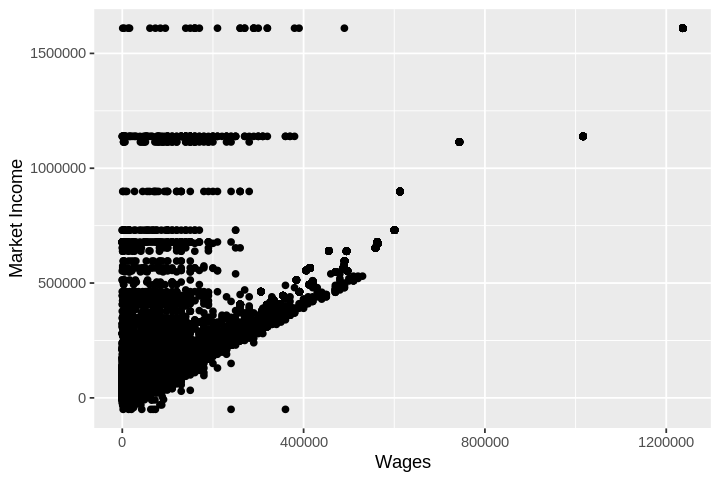

In [8]:
options(repr.plot.width=6,repr.plot.height=4) #controls the image size

initial_plot <- ggplot(data = census_data, aes(x = wages, y = mrkinc)) + xlab("Wages") + ylab("Market Income")
initial_plot + geom_point()

> _Think Deeper_: What do you see here?  Is there anything about this relationship that sticks out to you?  Why does it have the shape it does?

You can probably tell that there is definitely some relationship between wages and market income - but it can be difficult to visualize using a scatterplot alone.  There are far too many points, and too much going on.  

### Conditional Expectation:

The expectation of $X$  is what outcome we expect X to be after a LOT of sampling. For instance, the expectation of a die throw is 3. Essentially,
$$E[X] =  \sum_{i=1}^n P(X_i=x) X_i$$
Now the conditional expectation is, 
$$E[X|y_i=y] =  \sum_{i=1}^n P(X_i=x|y_i=y) X_i$$
Linear regression assumes a linear conditional expectation function $E[Y|X=x]= \beta_0 +\beta_1X$. This is what regression models are trying to approximate. Because regression models are only trying to obtain an estimate, we split them into two parts: the conditional exception and an error term.

### Regression Models

This is where a *regression model* comes in.  A regression model specifies (the *specification*) the relationship between two variables.  For example, a linear relationship would be:

$$M_i = \beta_0 + \beta_1 W_i$$

Where $M_i$ is the market income of individual $i$, and $W_i$ is their wage.  We normally (in econometrics) refer to $M_i$ as the **outcome** variable, and $$W_i$$ as the **explanatory** variable; you may have also heard the terms *dependent* and *independent*, but these aren't actually very good descriptions of what these variables are in econometrics, so we won't use them here.  

The formula above also contains two unknowns: $\beta_0$, $\beta_1$. 

* $\beta_0$ and $\beta_1$ are **parameters** of the model: they are numbers that determine the relationship (intercept and slope, respectively) between $M_i$ and $W_i$ 
* This is a linear relationship because the model we have specificied is linear in the coefficients (but there are many other kinds of models).  It is also linear in the variables, but that isn't required (we will see more about this later).

However, it is unlikely, if not impossible, for this relationship to completely explain everything about our data.  We need to include a term which captures everything which is _not_ described by the relationship we described in the model.  This is called the *residual* term (meaning "leftover").

* The $\epsilon_i$ is the residual: a component that corresponds to the part data which is _not_ described by the model (ie, documents the limitation of our model)
* These residual terms will usually have certain assumed properties that allow us to estimate the model.

As mentioned above, conceptually, we can think about a regression as two parts: the part of the relationship explained by our model ($M_i = \beta_0 + \beta_1 W_i$) and the part which is not explained ($\epsilon_i$).  The process of "fitting" or estimating a regression model refers to the selection of values for $\beta_0$ and $\beta_1$ such that as little needs to be explained by the residual term as possible (ie, we want as certain as we can about our model).  We write the complete regression equation by combining the two parts of the model:

$$M_i = \beta_0 + \beta_1 W_i + \epsilon_i$$

The goal of regression analysis is to:

1. Estimate this equation (and especially the model parameters) as accurately as possible.
2. Learn about the relationship between $M_i$ and $W_i$ from the results of that estimation.

There are many ways to define "accurately as possible" and similarly there are many ways to "estimate" the equation.  In this course, we use *ordinary least squares* (OLS) which says:

$$(\hat{\beta_0},\hat{\beta_1}) = \arg \min_{b_0,b_1} \sum_{i=1}^{n} (M_i - b_0 - b_1 W_i)^2 = \sum_{i=1}^{n} (e_i)^2$$

Okay, that looks complicated, but don't fear.  It is just the calculus way of writing "choose $\beta_0$ and $\beta_1$ (call them $\hat{\beta_0},\hat{\beta_1}$) such that they minimize the sum of the squared residuals".
* This should make sense; after all, the whole point of doing a regression is to explain as much as possible using the parameters ($\beta_0, \beta_1$) and as little as possible using $\epsilon_i$.
* This has transformed our statistical problem into a calculus problem, which we (well, a computer in our case) can solve; for example, by taking derivatives.

There are many, many ways to solve this estimation problem - most of which are built into R.  You can also solve it analytically (using some math).  But let's start with an alternative. Essentially, if you remember drawing a best fit line through points from your studies in high school, that is what a linear regression does in R.

### Example: Manual Estimation

A very *bad* way to solve this is the good-'ole eyeball method.  That's right - you look at the scatterplot, then guess some values and see how it performs. For obvious reasons, this is not used because it is not accurate or reliable.

Try to get the best fit you can by playing around with the following example.


In [9]:
#set the value of B_0 and B_1 with these values

B_0 = 0  # change me
B_1 = 1  # change me

# don't touch the rest of this code - but see if you can understand it!

SSE = sum((census_data$mrkinc - B_0 - B_1*census_data$wages)^2)

# here is the SSE from oour model

round(SSE/1000000,0)

[1] 553186549

What was the lowest value you got?  Here is what your guess looks like in a graph:



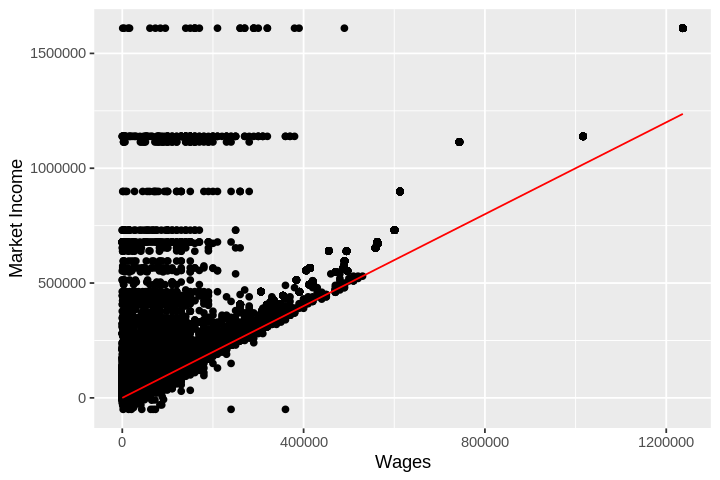

In [10]:
# run this cell to see your results
# re-run it if you change the values

options(repr.plot.width=6,repr.plot.height=4) #controls the image size

fitted_line = data.frame(wages = census_data$wages, mrkinc = B_0 + B_1*census_data$wages)

f <- ggplot(data = census_data, aes(x = wages, y = mrkinc)) + xlab("Wages") + ylab("Market Income")
f <- f + geom_point() + geom_line(color = "red", data = fitted_line)

f

## Simple Regressions in R

Now, let's see how we could use a regression in R to do this.  The main part of a regression model in R is the... model .  Not very surprising!  Regression models look like: `Y ~ X` (the `~` symbol is called "tilde" FYI).

* You ignore the residual terms and parameters when writing the model in R - just focus on the variables.

So, for example, our regression model is 

$$M_i = \beta_0 + \beta_1 W_i + \epsilon_i$$

Which can be written in R as

`mrkinc ~ wages`

Regressions are estimated in R using the `lm()` command, which also passes the arguments delineating the variables and data set of interest. The `lm()` command:
* Creates a **linear model_ object**, which can be used to calculate things (like prediction) or perform tests,
* Stores all of the information about the model, such as the coefficient and fit and 
* Can also be printed and summarized to give important basic information about a regression

If we were working with a linear model called `my_model`, some of the most important elements of the model that we could call on are:

* `my_model$coefficients`: the parameter coefficients
* `my_model$residuals`: the residuals
* `my_model$fitted.values`: the predicted values

Enough talk! Let's see our model in action here.


In [1]:
regression1 = lm(mrkinc ~ wages, data = census_data) # remember to place our variables in this order: Y ~ X 

summary(regression1)

head(regression1$coefficients)

ERROR: Error in is.data.frame(data): object 'census_data' not found


Take a close look at the results.  Identify the following elements:

* The values of the parameters 
* The standard errors of the parameters
* The %-of the data explained by the model (R-sqaured)

> **Test Your Knowledge**: What  %-of the data is explained by the model?  Answer to 2 decimal places.



In [ ]:
answer1 <- #answer goes here

test_1()

The underlying model and the parameters tell us about the relationship between the different values. When we plug in the results from our regression output, we create the following formula:

$$M_i = -2,464 + 1.61 W_i + \epsilon_i$$

Notice, for example:

$$\frac{\partial M_i}{\partial W_i} = \beta_1 = 1.61$$

In other words, when wages go up by 1 dollar, we would expect that market income will rise by 1.61 dollars. 

Finally, let's visualize our fitted model on the scatter plot from before.  How does it compare to your original model?

In [2]:
fitted_line2 = data.frame(wages = census_data$wages, mrkinc = regression1$fitted.values)

f <- ggplot(data = census_data, aes(x = wages, y = mrkinc)) + xlab("Wages") + ylab("Market Income")
f <- f + geom_point() + geom_line(color = "red", data = fitted_line) + geom_line(color = "blue", data = fitted_line2)

f

ERROR: Error in data.frame(wages = census_data$wages, mrkinc = regression1$fitted.values): object 'census_data' not found


As you can see - there's a very close relationship between `mrkinc` and `wages`.  This implies that we can focus our attention on wages in our analysis of the immigrant wage gap.

# Part 2: Simple Regressions and $t$-Tests

Previously, we looked at the relationship between market income and wages which are both _quantitative_ variables.  What would we do if we wanted to work with a _qualitative_ variable like `immstat`? Let's explore this situation now.

Regression models can still incorporate qualitative variables - which is good, because (as the Census makes clear) this is the most common type of variable in real-world data.  How is this possible?  

Let's start out with the simplest kind of qualitative variable: a **dummy** (0 or 1) variable.  Consider the regression equation:

$$W_i = \beta_0 + \beta_1 I_i + \epsilon_i$$

Consider the conditional expectation:

$$E[W_i|I_i = 1] = \beta_0 + \beta_1 \cdot 1 + E[\epsilon_i|I_i = 1]$$

$$E[W_i|I_i = 0] = \beta_0 + \beta_1 \cdot 0 + E[\epsilon_i|I_i = 0]$$


Under Assumption 1, we have that $E[\epsilon_i|I_i] = 0$, so:

$$E[W_i|I_i = 1] = \beta_0 + \beta_1$$

$$E[W_i|I_i = 0] = \beta_0$$

Combining these two expressions:

$$\beta_1 = E[W_i|I_i = 1] - E[W_i|I_i = 0]$$

What this tells us:

1.  You can include **dummy** variables in regressions
2.  The coefficients on the dummy variable have meaning in terms of the regression model
3.  The coefficients measure the (average) difference in the dependent variable between the two levels of the dummy variable

It is important to keep this in mind, since in terms of using regression models, what this tells us is that dummy variables can be included in a regression model just like quantitative variables.

Let's look at this in terms of `immstat`.  We can create our regression equation as:

$$W_i = \beta_0 + \beta_1 I_i + \epsilon_i$$

Then we can estimate this using R.


In [3]:
regression2 <- lm(wages ~ immstat, data = census_data)

summary(regression2)

ERROR: Error in is.data.frame(data): object 'census_data' not found


What do you see here?

> **Test Your Knowledge**:  What is the difference in average wage between immigrants and non-immigrants?

In [ ]:
#input the answer (to 1 decimal place)
answer2 <- ###? 

test_2()

The number about might seem familiar, if you remember what we learned about a $t$-test from earlier.  Remember this result?

In [ ]:
t1 <- t.test(x = filter(census_data, immstat == "immigrants")$wages,
       y = filter(census_data, immstat == "non-immigrants")$wages,
       alternative = "two.sided",
       mu = 0,
       conf.level = 0.95)
t1

t1$estimate[1] - t1$estimate[2]

Look closely at this result, and the result above.  What do you see?  What is the relationship here?

This is a very important result: regression is an example of the comparison that a two sample comparison is making, when the explanatory variable is a dummy.  Why is this?  Recall:

$$\beta_1 = E[W_i|I_i = 1] - E[W_i|I_i = 0]$$

The regression coefficient of $\beta_1$ has the interpretation of being a comparison of two means.  This is exactly the same as what the $t$-test is doing!  Comparing two means by different groups - groups which are specified by $I_i = 0$ or $I_i = 1$.

In other words, another way of thinking about a regression is like a form of _super_ comparison of means test. It can handle the same kind of analysis (i.e. with dummies), but also include quantitative variables, which regular comparison of means tests cannot handle.

# Part 3: Exercises

### Activity 1

We'll begin our excercises by looking at how the immigrant wage gap plays out across a person's sexual identity marker. 

>  <span style="color:#CC7A00" > 🔎 **Let's think critically** </span> \
> 🟠 Note that in this dataset, sex and gender are used synonymously to describe two binary classes. In real life, a person's gender may not correspond to the sex assigned to them at birth, or even to a classification of sexual identity that exists in the view of Western hegemonic gender and sexuality tradition; as such, notions of sexuality and gender are best understood to exist on a spectrum rather than a binary class. \
🟠 As you continue in your studies in econometrics, we invite you to consider the ways that coding can reinforce exclusionary logics and dis/misrepresent certain people groups. \
🟠 If you are interested in learning more about Statistics Canada's work in diversifying gender and sexual expression in the national census for 2021 you can read their [technical report on sex at birth and gender](https://www12.statcan.gc.ca/census-recensement/2021/ref/98-20-0002/982000022020002-eng.cfm) issued in July 2020. 

Estimate the immigrant wage gap for males and for females using regressions.

<em>Tested objects:</em> `regm` (the regression for males), `regf` (the regression for females).

In [ ]:
#Quiz 1
# Fill in ... with your code below

#Regression for males
regm <- lm(... ~ ..., data = filter(census_data, ... == ...)) #what should replace the ???

#Regression for females
regf <-  ## copy the above, making the appropriate changes for females

summary(regm) #Allow us to view regm's coefficient estimates
summary(regf) #Same as above, but for regf

test_3() #Quiz1
test_4() #Quiz2

#### Short Answer 1
**Prompt:** How do we interpret the coefficient estimate on ``immstat`` in each of these regressions?

<font style="color:red">Answer in red here!</font>

#### Short Answer 2
**Prompt:** Compare the gaps. Is the immigrant wage gap larger for males or females? Why might that be?

<font style="color:red">Answer in red here!</font>

### Activity 2
Many studies have suggested that workers' wages increase as they age. In this activity, we will explore how the immigrant wage gap varies by age. First, let's see the factor levels of the ``agegrp``:

In [ ]:
levels(census_data$agegrp) #Run this!

As we can see, there are several age groups in this data frame, including ones that would not be particularly informative (example, children's earnings). Let's estimate the immigrant wage gap (with no controls) for five of these groups separately:
* 20 to 24 years
* 30 to 34 years
* 40 to 44 years
* 50 to 54 years
* 60 to 64 years

<em>Tested objects:</em> `reg5_20` (20 to 24 years), `reg5_50` (50 to 54 years)

In [ ]:
# Fill in ... with your code below
reg5_20 <- lm(... ~ ..., data = filter(census_data, agegrp == ...)) #what should replace the ???

reg5_30 <- #what should go here?  use the above

reg5_40 <- 

reg5_50 <- 

reg5_60 <-

# store the summaries (but don't show them!  too many!)
sum20 <- summary(reg5_20)
sum30 <- summary(reg5_30)
sum40 <- summary(reg5_40)
sum50 <- summary(reg5_50)
sum60 <- summary(reg5_60)


test_12() #Quiz3
test_16() #Quiz4

The code below will tabulate a brief summary of each regression:

In [ ]:
# just run me!  You don't need to edit this

Age_Group <- c("20-24", "30-34", "40-44", "50-54", "60-64")
Wage_Gap <- c(reg5_20$coefficients[2], reg5_30$coefficients[2], reg5_40$coefficients[2], reg5_50$coefficients[2], reg5_60$coefficients[2])
Std._Error <- c(sum20$coefficients[2,2], sum30$coefficients[2,2], sum40$coefficients[2,2], sum50$coefficients[2,2], sum60$coefficients[2,2])
t_Value <- c(sum20$coefficients[2,3], sum30$coefficients[2,3], sum40$coefficients[2,3], sum50$coefficients[2,3], sum60$coefficients[2,3])
p_Value <- c(sum20$coefficients[2,4], sum30$coefficients[2,4], sum40$coefficients[2,4], sum50$coefficients[2,4], sum60$coefficients[2,4])

tibble(Age_Group, Wage_Gap, Std._Error, t_Value, p_Value) #it's like a table but a tibble

#### Short Answer 3
**Prompt**: What happens to the immigrant wage gap as we move across age groups? What might explain these changes?

<font style="color:red">Answer in red here!</font>

### Activity 3
The immigrant wage gap could also differ by education level. Since there are many education categories, however, we may not want to examine this by running a regression for each education level separately. 

Instead, we could run a single regression and add education level as a second regressor, $E_i$: 

$$W_i = \beta_0 + \beta_1 I_i + \beta_2 E_i + \epsilon_i$$

This is actually a **multiple regression**, which we will learn about later - but from the point of the this lesson, the idea is that it is "run" in R essentially in the same way as a simple regression.  Estimate the regression model above without $E_i$, then re-estimate the model with $E_i$ added.

<em>Tested objects:</em> `reg2A` (regression without controls), `reg2B` (regression with controls).

In [ ]:
# Naive regression (just immstat)
# Fill in ... with your code below
reg2A <- lm(wages ~ immstat, data = census_data) #this one works already

#Regression with controls
reg2B <-  lm(wages ~ immstat + ..., data = census_data) #what should replace the ??? think about the model


summary(reg2A)
summary(reg2B)
#this will look ugly; try to look carefully at the output



test_7()
test_8() #Quiz 5

#### Short Answer 4
Prompt: Compare the estimated immigrant wage gap with and without $E_i$ in the regression. What happens to the gap when we add $E_i$? How do we interpret this?

<font style="color:red">Answer in red here!</font>

### Activity 4

Another topic of interest for labor economists that is related to the immigrant wage gap is racial wage discrimination -- the issue of workers of similar productivity being paid different wages on average because of their race. Consequently, we can also use regressions to estimate the racial wage gap.

Let's suppose that we want to estimate this racial wage gap. Run a regression (without controls) that does this.

<em>Test objects:</em> ``reg_race``.

In [ ]:
# Do not modify this line (sets "not a visible minority" as the reference level):
# Fill in ... with your code below

census_data$vismin <- relevel(census_data$vismin, ref = "not a visible minority")
#this is also how you set a different base level for a factor (handy!)

# Racial Wage Gap Regression

reg_race <- lm(.., data = census_data) #what model should we use here?

summary(reg_race)

test_10() #Quiz6

#### Short Answer 5
**Prompt**: How should we interpret the regression estimate for ``visminblack``? For which racial groups are the wage gaps largest?

<font style="color:red">Answer in red here!</font>

#### Short Answer 6
**Prompt**: With this racial wage gap in mind, let's return to the immigrant wage gap. Should we add explanatory variables for race to our regression from activity 2 and 3? Why or why not?

<font style="color:red">Answer in red here!</font>

### Theoretical Activity 1 Bonus
When we deal with large quantitative variables, we often take the natural log of it:

In [ ]:
wages = log(wages) #This is merely illustrative -- it cannot be run like this

You may recall that the derivative of the log of a variables is approximately equal to percentage change in the variables:

$$\frac{dln(x)}{dx} \approx \frac{\Delta x}{x}$$ 

Thus, when we find the marginal effect of some continuous regressor $X_i$ (say, ``mrkinc``):

$$ln(W_i) = \beta_0 + \beta_1 M_i + \epsilon_i \implies \frac{\Delta W_i}{W_i} \approx \beta_1$$

This allows us to interpret the changes in a <em>continuous</em> variable as associated with a percentage change in wages; for instance, if we estimate a coefficient of $0.02$ on ``mrkinc``, we say that when a worker's market income increases by 1 CAD, the corresponding wage increases by 2 percent on average.

Let's generate two variables that takes the natural log of the wage <em>and</em> market income from the ``census_data`` dataframe (hint: use a technique that we introduced last week). Then, estimate the effect of logarithmic market income on logarithmic wages.

<em>Tested Objects:</em> ``lnreg``

In [ ]:
#Generate log wage variable
census_data <- census_data %>%
               mutate(lnwages = ???) %>% #what goes here?
               mutate(lnmrkinc = ???) #what goes here?

#see the warning!?!

# fix NANs

census_data_logged <- census_data %>%
               filter(!???(lnwages)) %>% #what goes here?
               filter(!???(lnmrkinc)) #what goes here?

# Log Regression 
lnreg <- ???(???, data = census_data_logged) #fill me in in


summary(lnreg)

test_5() #Quiz7

#### Short Answer 9
Prompt: How do we interpret each of these estimates?  (Hint: what does a 1-unit change in the explanatory variable mean here?)

<font style="color:red">Answer in red here!</font>

#### Theoretical Answer 1
Prompt: Now, let's suppose that we want to estimate the percentage marginal effect of ``immstat`` on ``lnwages`` (i.e., the immigrant wage gap) from the following regression:

$$ln(W_i) = \beta_0 + \beta_1 I_i + \epsilon_i$$

That is, find:
$$\frac{\Delta W_i}{W_i}$$

as $I_i$ goes from 0 to 1.  Notice this is a dummy variable, so the "derivative" intuition you learned above won't work!

Are we able to safely use the precentage-change interpretation that we do above? Explain why or why not, using algebra where appropriate. Solve this problem using the following steps:

* First, find an expression for $W_i$, using the equation above (hint: exponentiate ($e^{ln(x)} = x$)
* Then, compute the expression of $W_i$ when $I_i = 1$ and when $I_i = 0$
* Find $\Delta W_i$ by comparing your expressions, and divide by $W_i$ when $I_i = 0$

<font style="color:red">Answer in red here!</font>

#### Theoretical Answer 2

In your answer above, what would happen if you went from  What about when $I_i = 1$ to $I_i = 0$?  Is it the same as before?  Explain why or why not.

<font style="color:red">Answer in red here!</font>

## Submitting Your Work
Each week, you will upload your workbook as **both a ``.ipynb`` and a PDF.** Below are instructions of how to do this:
* While viewing worksheet1, click on the ``File`` tab on the upper-left corner of the screen.
* From there, drag your cursor over ``Download as`` to see the formats that you can export the worksheet to.
* To export to a ``.ipynb``, click on **"Notebook (.ipynb)."**
* Next, to export to a PDF, navigate back to ``File`` > ``Download as`` and click on **"PDF via LaTeX."**
* Upload both of these files to Canvas through the Assignments tab, as you would any other assignment.

Once you have finished uploading both of these files, you have completed the hands-on activity -- well done!